In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import chainer
import chainer.links as L
import chainer.functions as F
from chainer.links import caffe
from chainer.serializers import npz

In [4]:
## save caffemodel needed once
caffemodel = caffe.CaffeFunction('../VGG_CNN_M_2048.caffemodel')
npz.save_npz('VGG_CNN_M_2048.npz', caffemodel, compression=False)

FileNotFoundError: [Errno 2] No such file or directory: '../VGG_CNN_M_2048.caffemodel'

In [2]:
model_npz = np.load('./VGG_CNN_M_2048.npz')
print(model_npz.keys())

FileNotFoundError: [Errno 2] No such file or directory: '../Chainer_Realtime_Multi-Person_Pose_Estimation/VGG_CNN_M_2048.npz'

In [97]:
# define MyVGG
class VGG(chainer.Chain):
    def __init__(self, pretrained_model='VGG_CNN_M_2048.npz'):
        super(VGG, self).__init__()
        with self.init_scope():
            self.base = BaseVGG()
            self.fc6 = L.Linear(None, 4096)
            self.fc7 = L.Linear(4096, 2048)
        npz.load_npz(pretrained_model, self.base)
            
    def __call__(self, x):
        h = self.predict(x)
        return h
        
    def predict(self, x):
        h = self.base(x)
        h = F.dropout(F.relu(self.fc6(h)), ratio=.5)
        h = F.dropout(F.relu(self.fc7(h)), ratio=.5)
        return h

In [91]:
# define VGG_CNN_M_2048
class BaseVGG(chainer.Chain):
    def __init__(self):
        super(BaseVGG, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, out_channels=96, ksize=7, stride=2)
            self.conv2 = L.Convolution2D(96, out_channels=256, ksize=5, stride=2)
            self.conv3 = L.Convolution2D(256, out_channels=512, ksize=3, pad=1)
            self.conv4 = L.Convolution2D(512, out_channels=512, ksize=3, pad=1)
            self.conv5 = L.Convolution2D(512, out_channels=512, ksize=3, stride=2)
            
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.local_response_normalization(h, n=5, k=2, alpha=0.0005, beta=0.75)
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        
        h = F.relu(self.conv2(h))
        h = F.local_response_normalization(h, n=5, k=2, alpha=0.0005, beta=0.75)
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        
        h = F.relu(self.conv3(h))
        
        h = F.relu(self.conv4(h))
        
        h = F.relu(self.conv5(h))
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        
        return h

(224, 224, 3)
(1, 3, 224, 224)


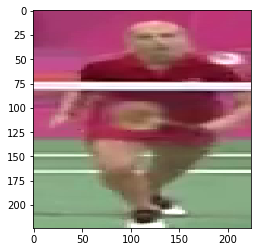

In [7]:
# 入力画像サイズの定義
image_shape = (224, 224)

# 画像を読み込み、RGB形式に変換する
image = Image.open('./data/crop_01.png').convert('RGB')
# 画像のリサイズとクリップ
image_w, image_h = image_shape
w, h = image.size
if w > h:
    shape = [image_w * w / h, image_h]
else:
    shape = [image_w, image_h * h / w]
x = (shape[0] - image_w) / 2
y = (shape[1] - image_h) / 2
image = image.resize(image_shape)
#image = image.crop((x, y, x + image_w, y + image_h)) # cropしない
pixels = np.asarray(image).astype(np.float32)
print(pixels.shape)


# pixelsは3次元でそれぞれの軸は[Y座標, X座標, RGB]を表す
# 入力データは4次元で[画像インデックス, BGR, Y座標, X座標]なので、配列の変換を行う
# RGBからBGRに変換する
pixels = pixels[:,:,::-1]

# 軸を入れ替える
pixels = pixels.transpose(2,0,1)

# 平均画像を引く
mean_image = np.ndarray((3, 224, 224), dtype=np.float32)
mean_image[0] = 103.939
mean_image[1] = 116.779
mean_image[2] = 123.68
pixels -= mean_image

# 4次元にする
pixels = pixels.reshape((1,) + pixels.shape)
plt.imshow(image)
print(pixels.shape)

In [8]:
# check the outputs of VGG
model = VGG()

y = model(pixels)
y = F.softmax(y).data
y.max(axis=1)

NameError: name 'VGG' is not defined

In [109]:
# disable to learn weght in baseVGG
model = VGG()
optimizer = chainer.optimizers.MomentumSGD()
optimizer.setup(model)
model.base.disable_update()

In [119]:
y = model(pixels)
y = F.softmax(y).data
y.max(axis=1)

array([ 0.72818965], dtype=float32)

In [3]:
n = [64, 96]

# keras code from here

In [1]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, merge, Lambda
from keras.layers.core import *
from keras.layers.convolutional import *
from keras.layers.recurrent import *

import tensorflow as tf
from keras import backend as K

from keras.activations import relu
from functools import partial
clipped_relu = partial(relu, max_value=5)

Using TensorFlow backend.


In [2]:
def max_filter(x):
    # Max over the best filter score (like ICRA paper)
    max_values = K.max(x, 2, keepdims=True)
    max_flag = tf.greater_equal(x, max_values)
    out = x * tf.cast(max_flag, tf.float32)
    return out

def channel_normalization(x):
    # Normalize by the highest activation
    max_values = K.max(K.abs(x), 2, keepdims=True)+1e-5
    out = x / max_values
    return out

def WaveNet_activation(x):
    tanh_out = Activation('tanh')(x)
    sigm_out = Activation('sigmoid')(x)  
    return Merge(mode='mul')([tanh_out, sigm_out])

In [3]:
# How many latent states/nodes per layer of network
# Only applicable to the TCNs. The ECCV and LSTM  model suses the first element from this list.
n_nodes = [64, 96] # 
nb_epoch = 200 # epoch数
video_rate = 3 #
conv = 20 # convolution のノード数

# n_classes = data.n_classes
# train_lengths = [x.shape[0] for x in X_train]
# test_lengths = [x.shape[0] for x in X_test]
# n_train = len(X_train)
# n_test = len(X_test)

# n_feat = data.n_features
# print("# Feat:", n_feat)

model_type = "ED-TCN"

In [24]:
20/2, 20//2

(10.0, 10)

In [4]:
def ED_TCN(n_nodes, conv_len, n_classes, n_feat, max_len, 
            loss='categorical_crossentropy', causal=False, 
            optimizer="rmsprop", activation='norm_relu',
            return_param_str=False): # n_feat次元のmax_lenベクトル
    n_layers = len(n_nodes)

    inputs = Input(shape=(max_len,n_feat)) # 期待される入力ベクトルが(max_len, n_feat)のバッチ。バッチサイズは含まれない
    model = inputs

    # ---- Encoder ----
    for i in range(n_layers):
        # Pad beginning of sequence to prevent usage of future data
        if causal: model = ZeroPadding1D(padding=(conv_len//2, 0))(model) # 始めと終わりにそれぞれいくつのゼロを加えるか。(left_pad, right_pad) 
        model = Convolution1D(n_nodes[i], kernel_size=conv_len, border_mode='same')(model) # 出力(max_len,64), kernel_size=conv, 
        if causal: model = Cropping1D(padding=(0, conv_len//2))(model) # (10/2, 10//2)=(5.0, 5)

        model = SpatialDropout1D(0.3)(model)
        
        if activation=='norm_relu': 
            model = Activation('relu')(model)            
            model = Lambda(channel_normalization, name="encoder_norm_{}".format(i))(model)
        elif activation=='wavenet': 
            model = WaveNet_activation(model) 
        else:
            model = Activation(activation)(model)            
        
        model = MaxPooling1D(pool_size=2)(model)

    # ---- Decoder ----
    for i in range(n_layers):
        model = UpSampling1D(2)(model) # 時間軸方向にそれぞれの時間ステップをsize=2回繰り返す
        if causal: model = ZeroPadding1D((conv_len//2,0))(model)
        model = Convolution1D(n_nodes[-i-1], conv_len, border_mode='same')(model)
        if causal: model = Cropping1D((0,conv_len//2))(model)

        model = SpatialDropout1D(0.3)(model)

        if activation=='norm_relu': 
            model = Activation('relu')(model)
            model = Lambda(channel_normalization, name="decoder_norm_{}".format(i))(model)
        elif activation=='wavenet': 
            model = WaveNet_activation(model) 
        else:
            model = Activation(activation)(model)

    # Output FC layer
    model = TimeDistributed(Dense(n_classes, activation="softmax"))(model) # units=出力次元数、 タイムスタンプのレイヤーそれぞれにDenseを適用するため
    
    model = Model(input=inputs, output=model)
    model.compile(loss=loss, optimizer=optimizer, sample_weight_mode="temporal", metrics=['accuracy']) # 訓練過程の設定, "temporal"=時間ごとのサンプルの重み付け（2次元の重み）を行う

    if return_param_str:
        param_str = "ED-TCN_C{}_L{}".format(conv_len, n_layers)
        if causal:
            param_str += "_causal"
    
        return model, param_str
    else:
        return model

In [5]:
model = ED_TCN(activation=causal=conv_len=loss=max_len=n_classes=n_feat=n_nodes=optimizer=return_param_str=)
model.Summary

TypeError: ED_TCN() missing 5 required positional arguments: 'n_nodes', 'conv_len', 'n_classes', 'n_feat', and 'max_len'

In [11]:
n_classes = 12
n_feat = 2
max_len = 20
causal = False

model, param_str = ED_TCN(n_nodes, conv, n_classes, n_feat, max_len, causal=causal, activation='norm_relu', return_param_str=True)     

/Users/daichi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 20, padding="same")`
  
/Users/daichi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(96, 20, padding="same")`
  
/Users/daichi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(96, 20, padding="same")`
/Users/daichi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 20, padding="same")`
/Users/daichi/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`


In [16]:
from keras.models import model_from_json
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 2)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 64)            2624      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 64)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 20, 64)            0         
_________________________________________________________________
encoder_norm_0 (Lambda)      (None, 20, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 96)            122976    
__________

In [17]:
json_string = model.to_json()
json_string

'{"class_name": "Model", "config": {"name": "model_1", "layers": [{"name": "input_1", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 20, 2], "dtype": "float32", "sparse": false, "name": "input_1"}, "inbound_nodes": []}, {"name": "conv1d_1", "class_name": "Conv1D", "config": {"name": "conv1d_1", "trainable": true, "filters": 64, "kernel_size": [20], "strides": [1], "padding": "same", "dilation_rate": [1], "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"name": "spatial_dropout1d_1", "class_name": "SpatialDropout1D", "config": {"name": "spatial_dropout1d_1", "trainable": true, "rate": 0.3, "noise